Dieses Notebook ist angelehnt an das Buch *Python Data Science Handbook* von Jake VanderPlas, auch verfügbar auf [GitHubPages](https://jakevdp.github.io/PythonDataScienceHandbook/).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Hilfsfunktionen

In [2]:
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact

# Hilfsfunktion zur Visualisierung
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, 
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='rainbow',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow',
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)

def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 2,3,4, 5])

def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 2,3,4, 5])


def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False,
                       xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0, 100]);

# Decision Trees und Random Forests

[Video](https://mstream.hm.edu/paella/ui/watch.html?id=dd574ba6-aba9-44d2-8881-b4519ea86d42)

**Ziel:** Klassifizierung von Daten

**Vorteile von Random Forests:**
- Training und Vorhersagen sind sehr schnell und können ggf. einfach parallelisiert werden
- Probabilistische Aussagen sind möglich (wie sicher ist sich der Klassifizierer bei einem gegebenen Datenpunkt)
- Sehr vielseitig einsetzbar, insbesondere wenn andere einfache Estimators underfitten

**Nachteil:** Nicht sonderlich gut zu interpretieren.

*Random Forests* sind ein Beispiel für eine sog. *Ensemble* Methode. Ensemble Methoden verwenden viele (einfache) Modelle und kombinieren diese zu einem einzigen Modell. Erstaunlicherweise (?) führt diese Kombination zu einem Modell, welches wesentlich mächtiger ist als seine einzelnen Bestandteile.

Ein *Random Forest* ist ein Ensemble, welches sich aus vielen einzelnen *Decision Trees* zusammensetzt.

## Decision Trees
Bei Decision Trees ("Entscheidungsbäumen") geht es darum, ein Objekt zu klassifizieren, indem *nacheinander* eine Reihe von Fragen gestellt wird, welche jeweils mit "ja" oder "nein" beantwortet werden können.

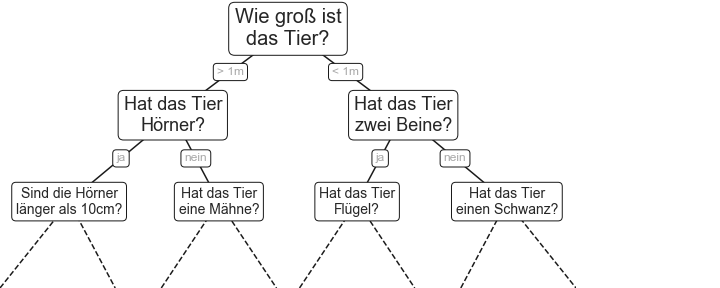

Die Qualität eines solchen Entscheidungsbaums wird durch die gestellten Fragen definiert: Eine gut gewählte Frage halbiert die Anzahl der verbleibenden möglichen Antworten. Somit kann selbst eine sehr große Anzahl an verfügbaren Kategorien sehr schnell eingeengt werden.

In Machine Learning Anwendungen von Entscheidungsbäumen sorgen die Fragen in der Regel für eine Aufteilung der Daten entlang einer Achse. D.h. eine Frage bezieht sich auf genau ein Feature und teilt die Daten dann auf, jenachdem ob bei einem gegebenen Datenpunkt dieses eine Feature oberhalb oder unterhalb eines Grenzwerts (definiert durch die Frage) liegt.

### Erstellen eines Decision Trees
Wir verwenden folgende Beispieldaten, die in vier Kategorien unterteilt sind:

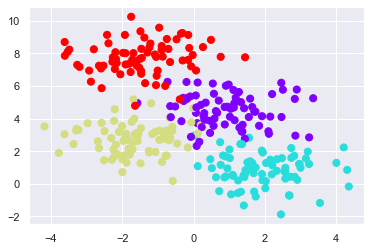

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

In diesem Fall wird ein Entscheidungsbaum auf jedem Level ("Knoten", entspricht einer Frage) die Daten entweder entlang der x- oder y-Achse aufteilen. Sowohl die Frage bzgl. welcher Achse geteilt wird, als auch die Frage, an welcher Stelle geteilt wird, muss vom Algorithmus beantwortet werden. Genauer: Das wird im Rahmen des Trainings gelernt.

Aufteilen heißt hier, dass alle Punkte auf der einen Seite Label A bekommen, die Punkte auf der anderen Seite bekommen Label B. In unserem Beispiel:
![](figures/04.05-decision-tree-levels.png)

**Wichtig:** In jedem Splitting wird jedes Gebiet, das noch nicht "fertig" ist, aufgeteilt. Im Beispiel ist die obere (rote) Hälfte bereits nach dem ersten Splitting "fertig", denn sie enthält nur Punkte einer Kategorie (rot). Das dritte Splitting teilt sowohl unten links als auch unten rechts. Das vierte Splitting geht bezogen auf seine Ausgangssituation (das Bild zu Tiefe = 3) folgendermaßen vor: Es teilt

- links unten nicht, da nur eine Kategorie
- links mittig parallel zur y-Achse, d.h. die Entscheidung ist $x < C$ oder $x \geq C$
- rechts unten parallel zur y-Achse, d.h. die Entscheidung ist $x < C$ oder $x \geq C$
- rechts mittig  parallel zur y-Achse, d.h. die Entscheidung ist $x < C$ oder $x \geq C$

In ``Scikit-Learn`` kann das durch den ``DecisionTreeClassifier`` gemacht werden:

In [4]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Damit können wir die Klassifizierung der Datenpunkte visualisieren:

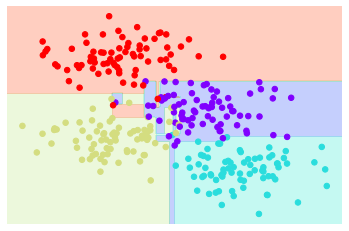

In [5]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [6]:
plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=4, options=(1, 2, 3, 4, 5), value=5), Output()), _do…

Ein tiefer Entscheidungsbaum kann dabei zu sehr merkwürdigen Aufteilungen führen. Hier sehen wir z.B. schon bei Tiefe 5 einen schmalen hohen lila Streifen zwischen dem gelben und dem türkisen Gebiet. Dieser kommt von einem Datenpunkt, der vermutlich eher als Rauschen interpretiert werden sollte.

Somit scheinen Decision Trees recht anfällig für Overfitting zu sein.

## Overfitting bei Decision Trees
Decision Trees sind allgemein anfällig für Overfitting, da man ohne viel Aufwand einen Entscheidungsbaum mit großer Tiefe verwenden kann. Damit können sehr viele Details der vorliegenden Daten abgebildet werden — obwohl eigentlich die zugrunde liegende Struktur gelernt werden sollte.

Eine andere Sichtweise auf Overfitting ist die Stabilitäts-Perspektive:
Ein gutes (stabiles) Verfahren sollte ein ähnliches Modell liefern, wenn man ähnliche Trainingsdaten verwendet. Konkret: Trainiert man das Modell einmal auf einer zufällig gewählten Hälfte der Daten und einmal auf dem verbleibenden Rest, so sollte ein ähnliches Modell entstehen.
Hier erhalten wir aber folgendes:

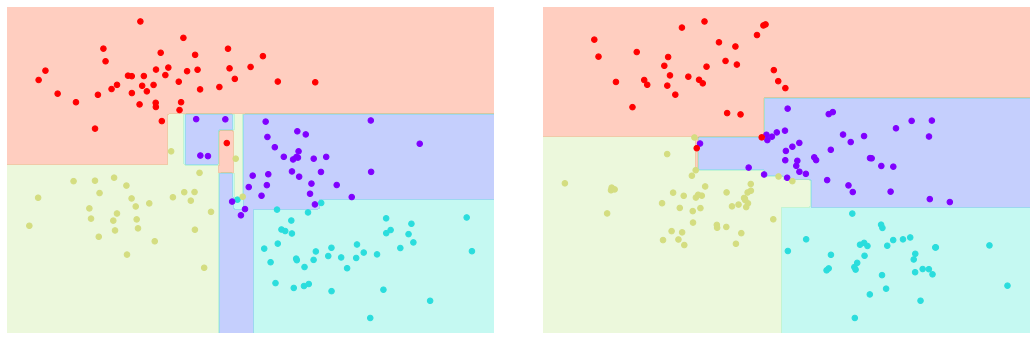

In [7]:
model = DecisionTreeClassifier()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0])
visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1])

Wir beobachten:

- In manchen Bereichen liefern beide Modelle die gleiche Klassifizierung; die Modelle sind sich einig. Das ist in den Bereichen der Fall, in denen die Entscheidung sehr "eindeutig" ist, also in den vier Ecken.
- In anderen Bereichen liefern beide Modelle unterschiedliche  Klassifizierungen; die Modelle sind sich *nicht* einig. Das ist in den Bereichen der Fall, in denen die Entscheidung eher unklar ist, also dort, wo sich unterschiedliche Klassen "treffen".

An dieser Stelle kommt nun der Gedanke ins Spiel, dass man die beiden Modelle doch kombinieren könnte, um ggf. eine bessere Klassifizierung zu erreichen. Und was man mit zwei Modellen machen kann, kann man auch mit vielen Modellen machen.

In [15]:
randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

## Random Forests
Der Grundgedanke ist also, dass wir viele Estimators verwenden, die allesamt overfitten. Diese kombinieren wir durch Mittelwertbildung und hoffen/erwarten, dass sich das Overfitting reduzieren wird. Denn: Jeder Estimator hat Details der ihm vorgelegten Daten gelernt, die unnütz sind; jeder Estimator hat aber *andere* solche Details gelernt. Das was wirklich wichtig ist (die zugrunde liegende Struktur), haben *alle* Estimators gelernt. Wenn man die vielen Estimators nun abstimmen lässt, werden sie sich in Bezug auf die wichtige Struktur einig sein und Punkte korrekt klassifizieren, bei verrauschten Daten werden sie sich aber nicht alle einig sein, die Mehrheit entscheidet.

Dieses Vorgehen nennt man **Bagging**. Ein Ensemble von zufälligen Decision Trees nennt man **Random Forest**.

Da Bagging ein prinzipielles Vorgehen ist, das für beliebige Estimators verwendet werden kann, ist es in SKLearn als Meta-Estimator verfügbar:

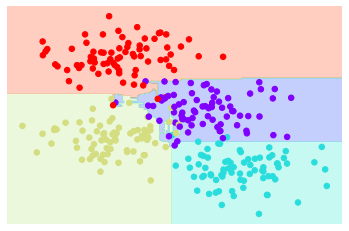

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

Hier haben wir den Zufall ins Spiel gebracht, indem wir 100 Decision Trees auf jeweils zufälligen 80% der Daten trainiert haben. Dieses Vorgehen erläutert das Prinzip Bagging recht anschaulich. In der Praxis ist es allerdings wünschenswert, dass jedes Modell auf den gesamten Daten trainiert wird. Daher fügt man den nötigen Zufall an anderer Stelle ein: bei der  Entscheidung, die in jeder Verzweigung des Baums getroffen wird. Die genauen Methoden mit der der "Zufall eingeführt" werden kann betrachten wir hier nicht.

Eine fertige Methode, die ein optimiertes Ensemble an Decision Trees erzeugt, ist mit ``RandomForestClassifier`` verfügbar. Der wesentliche hier zu wählenden Hyperparameter ist die Anzahl der Decision Trees, die verwendet werden sollen:

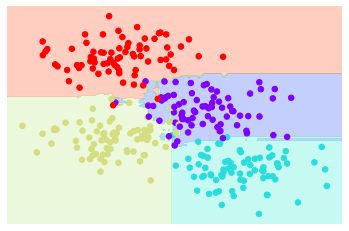

In [20]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

Das sieht doch ganz gut aus!

# Random Forest Regression
Diese Ideen können auch zur Konzipierung eines Estimators verwendet werden, der Regressions-Aufgaben löst. Ein solcher Estimator ist verfügbar als ``RandomForestRegressor``.

Diesen wollen wir verwenden, um folgende Beispieldaten zu lernen. Der Datengenerierungsprozess setzt sich zusammen auf einer langsamen und einer schnellen Schwingung und enthält ein gewisses Maß an Rauschen:

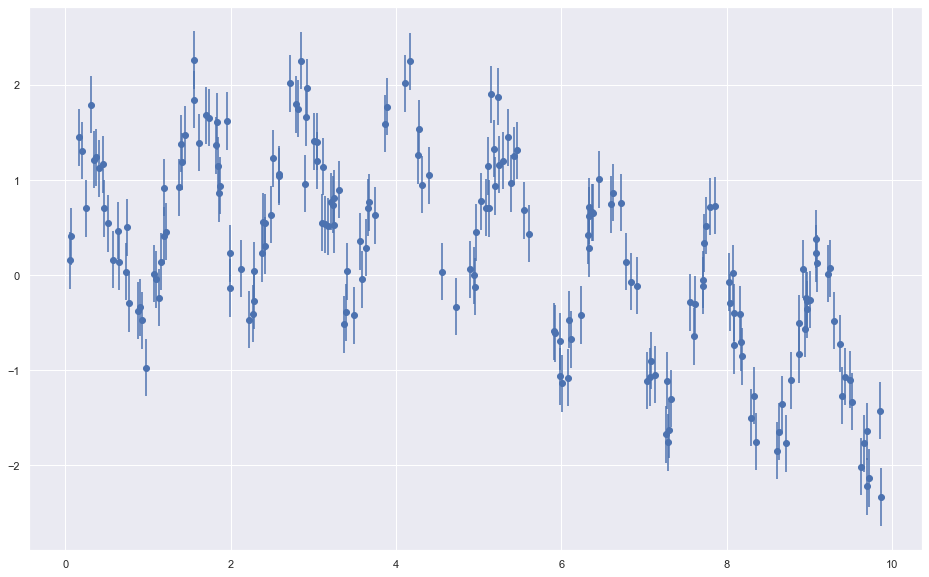

In [25]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def data(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = data(x, 0.3)
plt.figure(figsize=(16,10))
plt.errorbar(x, y, .3, fmt='o');

Wir wollen nun eine Kurve angeben, die diese Daten darstellt (aber nicht das Rauschen). Dafür verwenden wir einen ``RandomForestRegressor``:

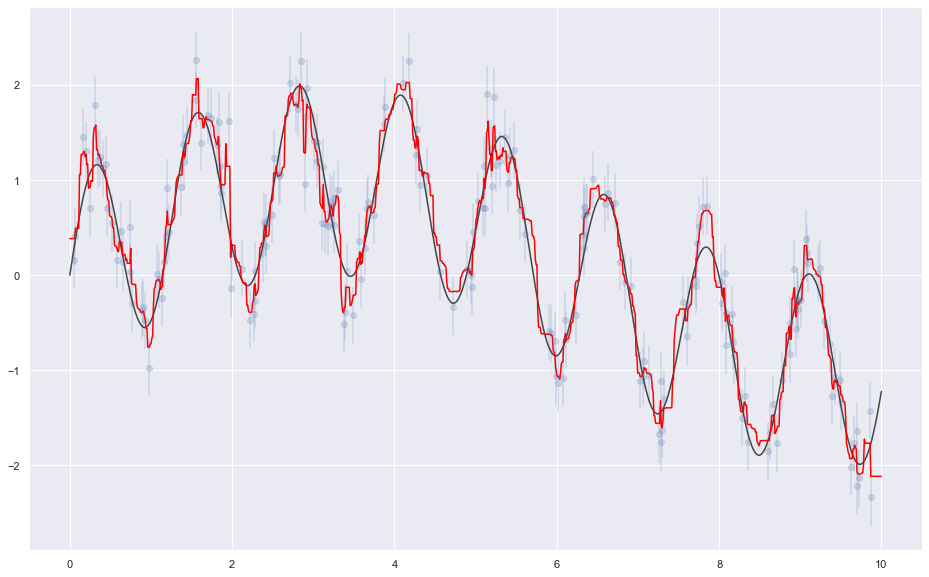

In [29]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = data(xfit, sigma=0)

plt.figure(figsize=(16,10))
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.2)
plt.plot(xfit, ytrue, '-k', alpha=.8);
plt.plot(xfit, yfit, c='red');

## Beispiel: Klassifizierung von handschriftlichen Zahlen
Wir betrachten nochmal die handschriftlichen Zahlen aus dem zweiten Praktikum und versuchen diese mit einem Random Forest zu klassifizieren.

Hier noch einmal die visuelle Darstellung der ersten 64 Ziffern:

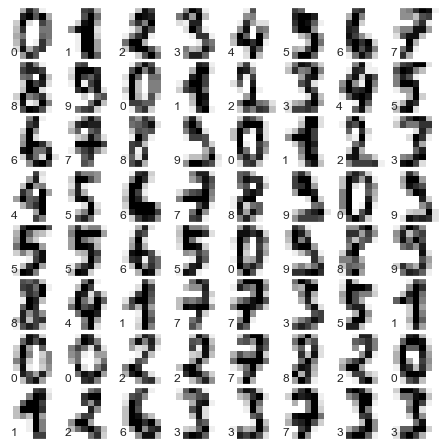

In [30]:
from sklearn.datasets import load_digits
digits = load_digits()

# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

- Zuerst teilen wir die Daten auf in Trainings- und Testdaten.
- Dann trainieren wir einen Random Forest und verwenden dieses trainierte Modell, um die Testdaten zu klassifizieren.

In [37]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Wir betrachten das Ergebnis in Form eines Classification Reports (siehe auch 04.03_SVM):

In [38]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Was bedeuten diese Werte? Auszug aus der ``sklearn`` Dokumentation:

The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of true positives and ``fp`` the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of true positives and ``fn`` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of ``beta``. ``beta == 1.0`` means recall and precision are equally important.

The support is the number of occurrences of each class in ``y_true``.

Eine Bewertung des Modells ist auch durch eine Confusion Matrix möglich:

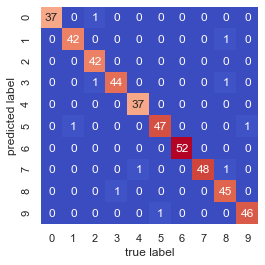

In [39]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='coolwarm')
plt.xlabel('true label')
plt.ylabel('predicted label');

Dieses einfache, nicht von uns optimierte Modell liefert sehr gute Ergebnisse.